In [98]:
import numpy as np
import matplotlib.pyplot as plt
import time as time_pkg

from astropy import units as u

from lib.GPUKeplerSimulation import propagate, average_scaler
from lib.DisplaySimulation import displaySimulation
from lib.AsteroidBelt import generateNearSHODistribution

20000,0.001120,0.100000,0.050000,0.000000,0.001919,0.100000,1000.000000,300.000000,0.500000,0.000756,1028.000000

In [99]:
size = 20000
r_0 = 0.05*u.km
epsilon = 0.0000001*u.kg*u.km**2/u.s
micro = 0.00112*u.km**3/u.s**2 
m = 0.1*u.kg

belt = generateNearSHODistribution(size, micro, m, r_0, epsilon)

UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions

In [93]:
micro = k
J_1 = micro*np.sqrt(m*r_0)
print("Action 1: ", J_1)
print("Energy: ", -np.power(micro,3)*np.power(m,2)/(2*np.power(J_1, 2)))
omega = np.power(np.sqrt(k/m),3)*np.power(m,2)/np.power(J_1, 3.0)
omega_prime = -3*np.sqrt(k/m)/np.power(r_0, 2.0)
print("Omega_0: ", omega)
print("Omega_prime: ", omega_prime)
print("Decoherence Time: ", 2*np.pi/(omega_prime*epsilon))

# average_radius = 3*sigma_e**2 + 3*sigma_e*sigma_a + 3*sigma_e*np.sqrt(r_0) + 2*sigma_a**2 + 2*sigma_a*np.sqrt(r_0) + r_0
# print("Initial average radius: ", average_radius)

Action 1:  7.919595949289333e-05 kg(3/2) km(7/2) / s2
Energy:  -0.0011199999999999997 kg2 km2 / s2
Omega_0:  23862610.885037884 s3 / (kg(5/2) km6)
Omega_prime:  -126.99606293110033 1 / (km(1/2) s)
Decoherence Time:  -494754.3382182192 s2 / (kg km(3/2))


In [92]:
np.power(micro, 4)*np.power(m,2)/np.power(J_1, 4)

<Quantity 400. 1 / km2>

In [95]:
k

<Quantity 0.00112 kg km3 / s2>

In [73]:
timestep = 0.1*u.second

time_before_kick = 1*u.second
time_after_kick = 1000*u.second
time_after_quad_kick = 1500*u.second

dipole_time = time_before_kick
quad_time = time_before_kick + time_after_kick
end_time = time_before_kick + time_after_kick + time_after_quad_kick

dipole_step = int(np.ceil(dipole_time/timestep))
quad_step = int(np.ceil(quad_time/timestep))
end_step = int(np.ceil(end_time/timestep))


time = np.linspace(0.0*u.second, end_time, end_step)

avr_radius = np.zeros(end_step) * u.km

radiuses = np.zeros((size, end_step)) * u.km
velocities = np.zeros((size, end_step)) * u.km/u.s

In [74]:
gpuStart = time_pkg.time()
radiuses[:,0:dipole_step], velocities[:,0:dipole_step], final_mean_anamoly = propagate(belt, dipole_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

GPU Time:  0.1719982624053955  Astro Time:  0.0019998550415039062


In [75]:
avr_radius[0:dipole_step] = average_scaler(radiuses, end=dipole_step)

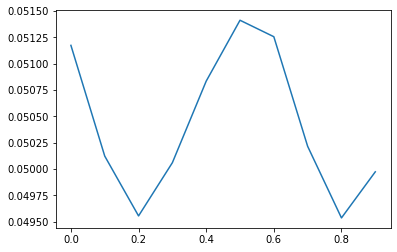

In [76]:
plt.plot(time[0:dipole_step], avr_radius[0:dipole_step])

In [77]:
belt.radial_kick(0.004040*u.km)

In [78]:
gpuStart = time_pkg.time()
radiuses[:,dipole_step:quad_step], velocities[:,dipole_step:quad_step], final_mean_anamoly = propagate(belt, quad_time-dipole_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

GPU Time:  18.492231369018555  Astro Time:  0.0


In [79]:
avr_radius[dipole_step:quad_step] = average_scaler(radiuses, start=dipole_step, end=quad_step)

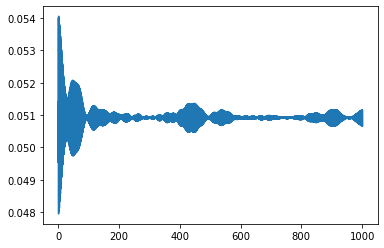

In [80]:
plt.plot(time[0:quad_step], avr_radius[0:quad_step])


In [ ]:
belt.radial_quadrapole_kick(1.1785 * u.s**-1, r_0)

In [ ]:
gpuStart = time_pkg.time()
radiuses[:,quad_step:end_step], velocities[:,quad_step:end_step], final_mean_anamoly = propagate(belt, end_time - quad_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

GPU Time:  1.3889951705932617  Astro Time:  0.0


In [ ]:
avr_radius[quad_step:end_step] = average_scaler(radiuses[quad_step:end_step], start=quad_step, end=end_step)

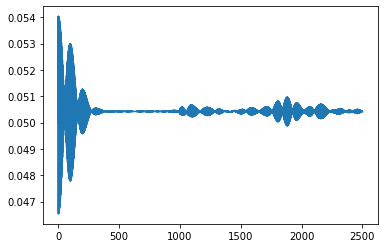

In [ ]:
plt.plot(time[0:end_step], avr_radius[0:end_step])